<a href="https://colab.research.google.com/github/zktuong/dandelion/blob/master/container/dandelion_singularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to `dandelion`
<img src='https://github.com/zktuong/dandelion/blob/master/docs/notebooks/img/dandelion_logo_illustration.png?raw=true'/>

Welcome to the Google Colab notebook example/tutorial for Dandelion! In this notebook, we will run through an example workflow for 1) pre-processing, 2) post-processing and 3) pseudobulk V(D)J trajectory.

## Preprocessing - V(D)J reannotation

We will try out the full reannotation workflow in this part of the colab notebook. To do that, we need to set up the other non-python dependencies. This is normally taken care of by the [singularity container](https://sc-dandelion.readthedocs.io/en/latest/notebooks/Q1-singularity-preprocessing.html) but it's very difficult to set it up on Google Colab architecture, so we will continue manually.

In [1]:
!pip install -q condacolab
import condacolab
# Run this block by itself first.
# This will lead to a kernel restart, so don't be alarm by the session crashing.
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


In [1]:
# download reannotation dependencies
!mamba install -y -qq -c bioconda -c conda-forge igblast blast r-optparse r-alakazam r-tigger r-airr r-shazam
# obtain the reference databases
!git clone -q https://github.com/zktuong/dandelion.git
# set paths to databases
import os
os.environ["IGDATA"] = "/content/dandelion/container/database/igblast/"
os.environ["GERMLINE"] = "/content/dandelion/container/database/germlines/"
os.environ["BLASTDB"] = "/content/dandelion/container/database/blast/"

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [2]:
# install dandelion and scanpy
!pip install -q sc-dandelion scanpy[leiden] networkx==2.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# import and show versions
import dandelion as ddl

ddl.logging.print_header()

dandelion==0.3.3 pandas==2.1.0 numpy==1.23.5 matplotlib==3.7.1 networkx==2.7 scipy==1.11.2


### Download example datasets from 10X

We will download example datasets freely available from 10X Genomics. To keep this part of the tutorial short, we will trim to just 1000 contigs in the files in the second block but definitely do try it again later on the full datasets!

In [ ]:
%%shell
if [ ! -d "/content/dandelion_tutorial/vdj_v1_hs_pbmc3" ]; then mkdir -p /content/dandelion_tutorial/vdj_v1_hs_pbmc3; fi
# cd /content/dandelion_tutorial/vdj_v1_hs_pbmc3 && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.h5;
cd /content/dandelion_tutorial/vdj_v1_hs_pbmc3 && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_b_filtered_contig_annotations.csv;
cd /content/dandelion_tutorial/vdj_v1_hs_pbmc3 && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_b_filtered_contig.fasta;

if [ ! -d "/content/dandelion_tutorial/vdj_nextgem_hs_pbmc3" ]; then mkdir -p /content/dandelion_tutorial/vdj_nextgem_hs_pbmc3; fi
# cd /content/dandelion_tutorial/vdj_nextgem_hs_pbmc3 && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_filtered_feature_bc_matrix.h5;
cd /content/dandelion_tutorial/vdj_nextgem_hs_pbmc3 && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_b_filtered_contig_annotations.csv;
cd /content/dandelion_tutorial/vdj_nextgem_hs_pbmc3 && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_b_filtered_contig.fasta;

if [ ! -d "/content/dandelion_tutorial/sc5p_v2_hs_PBMC_10k" ]; then mkdir -p /content/dandelion_tutorial/sc5p_v2_hs_PBMC_10k; fi
# cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_10k && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5;
cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_10k && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_filtered_contig_annotations.csv;
cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_10k && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_filtered_contig.fasta;

if [ ! -d "/content/dandelion_tutorial/sc5p_v2_hs_PBMC_1k" ]; then mkdir -p /content/dandelion_tutorial/sc5p_v2_hs_PBMC_1k; fi
# cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_1k && wget -q -O filtered_feature_bc_matrix.h5 wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_filtered_feature_bc_matrix.h5;
cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_1k && wget -q -O filtered_contig_annotations.csv wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_b_filtered_contig_annotations.csv;
cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_1k && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_b_filtered_contig.fasta;

In [ ]:
%%shell
# trim to just 1000 contigs to make this part of the tutorial shorter
cd /content/dandelion_tutorial/vdj_v1_hs_pbmc3 && head -1000 filtered_contig.fasta > filtered_1k_contig.fasta && sed -i '1,+999d' filtered_contig.fasta && head -1001 filtered_contig_annotations.csv > filtered_1k_contig_annotations.csv && sed -i '1,+1000d' filtered_contig_annotations.csv
cd /content/dandelion_tutorial/vdj_nextgem_hs_pbmc3 && head -1000 filtered_contig.fasta > filtered_1k_contig.fasta && sed -i '1,+999d' filtered_contig.fasta && head -1001 filtered_contig_annotations.csv > filtered_1k_contig_annotations.csv && sed -i '1,+1000d' filtered_contig_annotations.csv
cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_10k && head -1000 filtered_contig.fasta > filtered_1k_contig.fasta && sed -i '1,+999d' filtered_contig.fasta && head -1001 filtered_contig_annotations.csv > filtered_1k_contig_annotations.csv && sed -i '1,+1000d' filtered_contig_annotations.csv
cd /content/dandelion_tutorial/sc5p_v2_hs_PBMC_1k && head -1000 filtered_contig.fasta > filtered_1k_contig.fasta && sed -i '1,+999d' filtered_contig.fasta && head -1001 filtered_contig_annotations.csv > filtered_1k_contig_annotations.csv && sed -i '1,+1000d' filtered_contig_annotations.csv

## Preprocessing 10X data

Just like the [original tutorial](https://sc-dandelion.readthedocs.io/en/latest/notebooks/1_dandelion_preprocessing-10x_data.html), we will format the files, reannotate with `igblastn`, reassign the V gene alleles, assign the isotype calls and quantify mutations.

In [ ]:
os.chdir("/content/dandelion_tutorial")
samples = [
    "sc5p_v2_hs_PBMC_1k",
    "sc5p_v2_hs_PBMC_10k",
    "vdj_v1_hs_pbmc3",
    "vdj_nextgem_hs_pbmc3",
]
filename_prefixes = ["filtered_1k" for s in samples]

In [ ]:
ddl.pp.format_fastas(samples, prefix=samples, filename_prefix=filename_prefixes)

Formating fasta(s) : 100%|██████████| 4/4 [00:00<00:00, 20.05it/s]


In [ ]:
ddl.pp.reannotate_genes(samples, filename_prefix=filename_prefixes)


Assigning genes : 100%|██████████| 4/4 [06:22<00:00, 95.59s/it]


Processing data file(s) : 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.


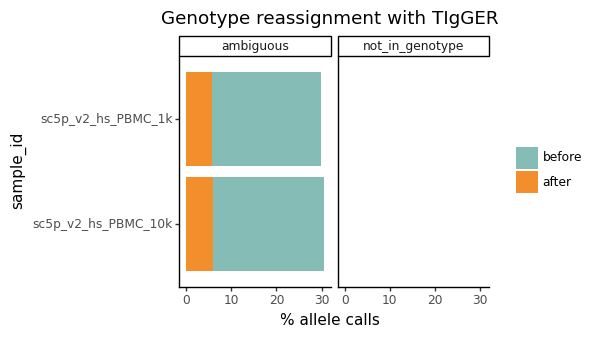

Writing out to individual folders : 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


In [ ]:
# reassigning alleles on the first set of samples
ddl.pp.reassign_alleles(
    samples[:2],
    combined_folder="tutorial_scgp1",
    filename_prefix=filename_prefixes,
)

Processing data file(s) : 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.


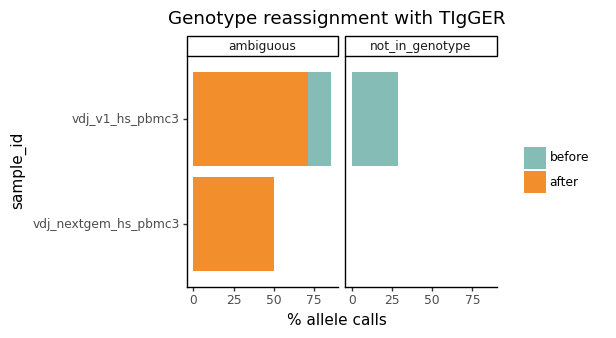

Writing out to individual folders : 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


In [ ]:
# reassigning alleles on the second set of samples
ddl.pp.reassign_alleles(
    samples[2:],
    combined_folder="tutorial_scgp2",
    filename_prefix=filename_prefixes,
)

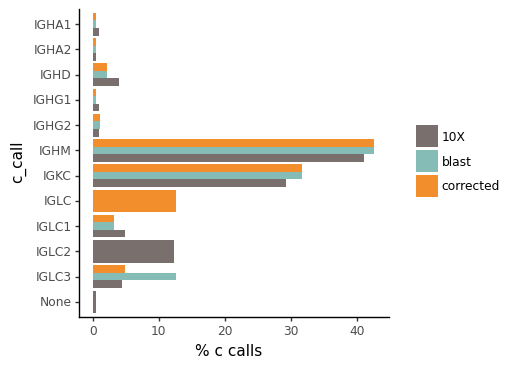

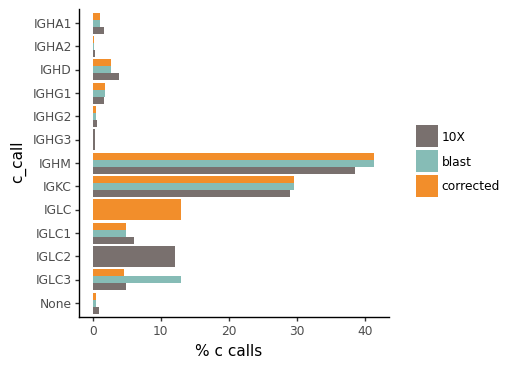

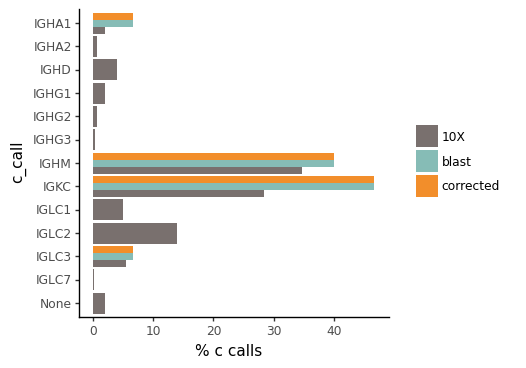

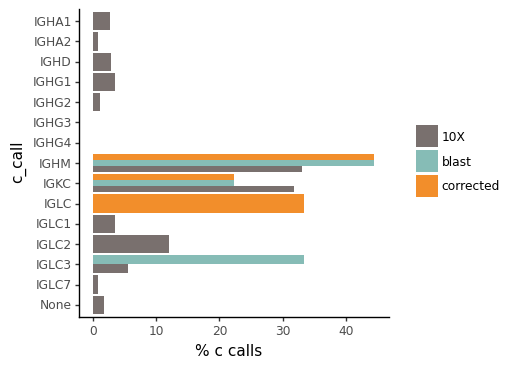

In [ ]:
ddl.pp.assign_isotypes(samples, filename_prefix=filename_prefixes)


In [ ]:
from tqdm import tqdm

# quantify mutations
for s in tqdm(samples, desc="Basic mutational load analysis "):
    filePath = s + "/dandelion/filtered_1k_contig_dandelion.tsv"
    ddl.pp.quantify_mutations(filePath)

Basic mutational load analysis : 100%|██████████| 4/4 [00:24<00:00,  6.24s/it]


And now we have a processed output (`filtered_1k_contig_dandelion.tsv`) in each folder that can be used for downstream exploration.

# Post-processing - V(D)J analysis

We will now switch to the post-processing tutorial. Let's follow the rest of the [original tutorial](https://sc-dandelion.readthedocs.io/en/latest/notebooks/Q2-analysis.html).

In [4]:
import dandelion as ddl
import scanpy as sc
import warnings
import os

warnings.filterwarnings("ignore")
ddl.logging.print_header()

dandelion==0.3.3 pandas==2.1.0 numpy==1.23.5 matplotlib==3.7.1 networkx==2.7 scipy==1.11.2


In [5]:
sc.logging.print_header()


scanpy==1.9.5 anndata==0.9.2 umap==0.5.3 numpy==1.23.5 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


Let’s run through some of what `Dandelion` can do in terms of analysis. In order to kickstart this tutorial, we prepared GEX and V(D)J objects with four demo 10X samples parsed for your convenience. You can download them from the ftp site as per below. The GEX has had some basic `Scanpy` analysis performed on it, all the way up to making a UMAP and calling Leiden clusters. The VDJ is just four calls of `ddl.read_10x_airr()`, with the individual objects saved to a list, which was then passed to `ddl.concat()` to get a combined `Dandelion` object. No analysis was done on this combined object.

In [6]:
if not os.path.exists("demo-gex.h5ad"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-gex.h5ad")

if not os.path.exists("demo-vdj.h5ddl"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-vdj.h5ddl")


Let’s import the objects. `Dandelion`’s h5ddl files can be read via `ddl.read_h5ddl()`.

In [7]:
adata = sc.read("demo-gex.h5ad")
vdj = ddl.read_h5ddl("demo-vdj.h5ddl")


At this point you’re probably wondering why there’s a separate Dandelion object. The reason is AIRR compliance. Some of the AIRR columns have more complex typing than what Scanpy can currently support within its objects. However, it’s quite straightforward to link up a Scanpy object with a `Dandelion` one.

In [8]:
vdj, adata = ddl.pp.check_contigs(vdj, adata)


Preparing data: 6490it [00:05, 1160.14it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 3158/3158 [00:28<00:00, 111.01it/s]


This filters the contigs and synchronises relevant information between the objects. Once linked up like this, any new information can be copied over from the Dandelion object via `ddl.tl.transfer()`.

For now, let’s take a look at the chain status (as gotten from the Dandelion object) and known BCR marker expression.

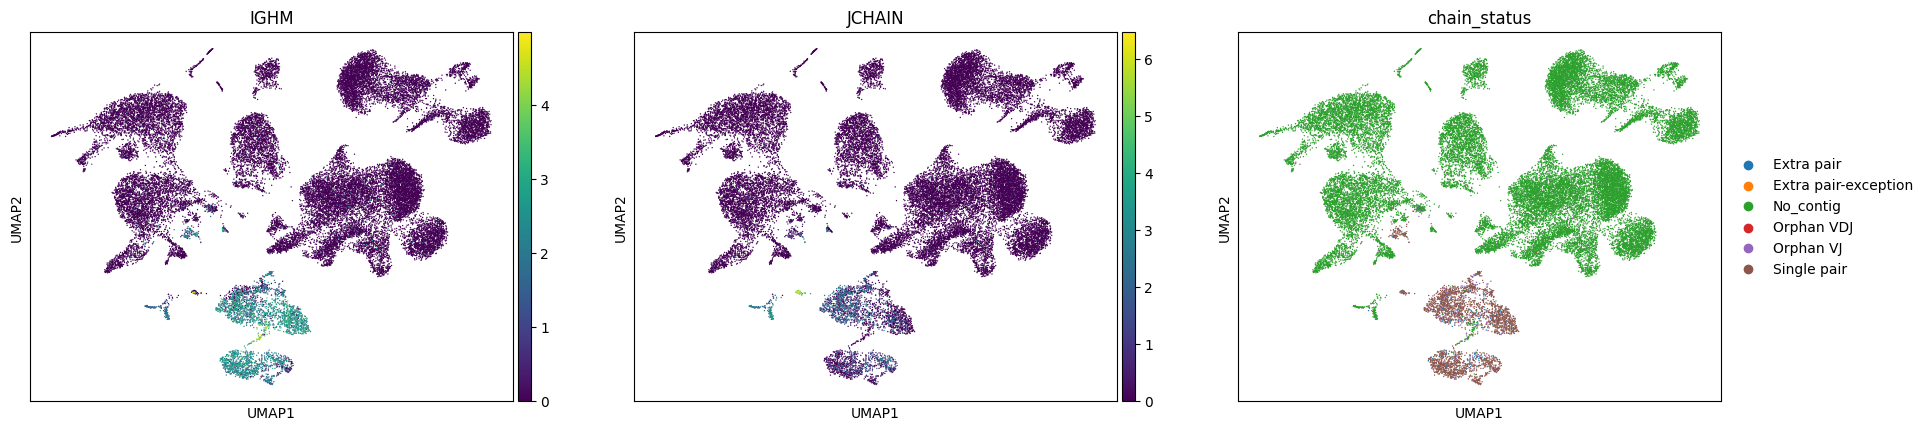

In [9]:
sc.pl.umap(adata, color=["IGHM", "JCHAIN", "chain_status"])

Under the hood, the `Dandelion` object is essentially two data frames. .data holds the AIRR-compliant contig space table, while `.metadata` is an `.obs` equivalent that parses the contig information to a cell level and can be easily integrated with a `Scanpy` object. There are also `ddl.to_scirpy()` and `ddl.from_scirpy()` for interoperability with `Scirpy`, as explored in a notebook in the extended tutorial.

In [10]:
vdj


Dandelion class object with n_obs = 3092 and n_contigs = 7340
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_bla

Now that we’ve got the gist of basic handling of the `Dandelion` object, let’s use it for some analysis!

A core element of V(D)J analysis is clonotype calling, roughly equivalent to clustering cells in GEX processing. `Dandelion` requires the clones it calls to have identical V and J genes, along with no more than 15% mismatches in the CDR3 sequences (common practice in BCR analysis).

In [11]:
ddl.tl.find_clones(vdj)


Finding clones based on B cell VDJ chains : 100%|██████████| 256/256 [00:00<00:00, 1201.46it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 2817/2817 [00:00<00:00, 192812.45it/s]


We can compute a graph based on Levenshtein distance of the complete contig sequence. A NetworkX representation of it is now saved in `vdj.graph`.

In [12]:
ddl.tl.generate_network(vdj)


Setting up data: 6229it [00:05, 1213.41it/s]
Linking edges : 100%|██████████| 2722/2722 [00:00<00:00, 10809.95it/s]


To benefit from faster layout computation, please install graph-tool: conda install -c conda-forge graph-tool


`graph-tool` is very difficult to install on Google Colab so we will skip that for now.

Since we now know what our clonotype calls are, we can quantify clonal expansion. It’s possible to cap this at a desired maximum clonotype size.

In [13]:
ddl.tl.clone_size(vdj)
ddl.tl.clone_size(vdj, max_size=3)

Now that our Dandelion object has analysis information inside it, we can copy it over to the Scanpy object to have access to it there. The graph gets turned into the Scanpy standard forms of `.obsp['vdj_distances']` and `.obsp['vdj_connectivites']` for potential downstream use.

In [14]:
ddl.tl.transfer(adata, vdj)


Let’s take a look at what we made!

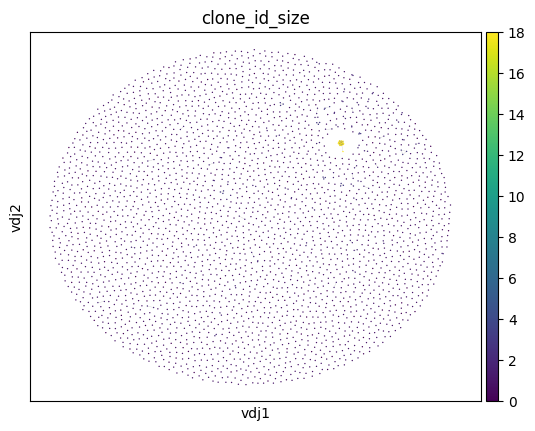

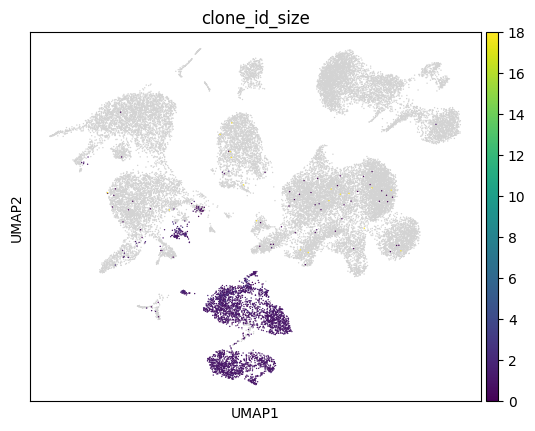

In [15]:
ddl.pl.clone_network(adata, color="clone_id_size")
sc.pl.umap(adata, color="clone_id_size")

Wait, why are we seeing some clone size 0 in the plots? Orphan chains.

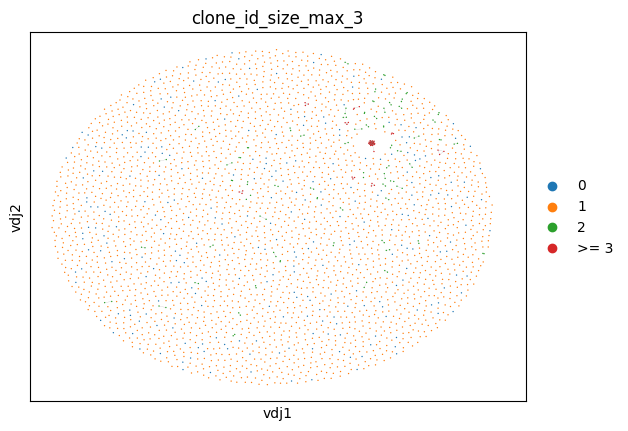

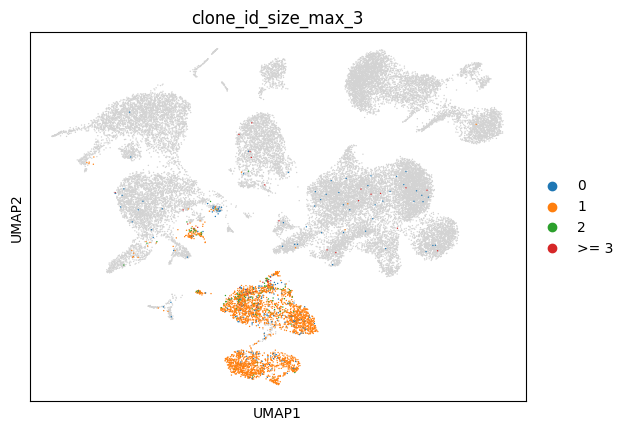

In [16]:
ddl.pl.clone_network(adata, color="clone_id_size_max_3", na_in_legend=False)
sc.pl.umap(adata, color="clone_id_size_max_3", na_in_legend=False)

Dandelion comes with a number of plotting functions for your convenience. However, those functions tend to operate best without the Scanpy plotting defaults in place. You can reset Matplotlib’s configuration prior to using them.

In [17]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

We’ve got bar plots.

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'v call genotyped VDJ usage'}, ylabel='proportion'>)

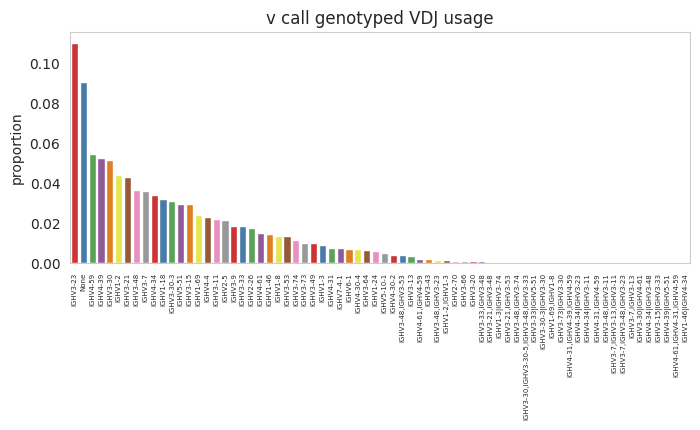

In [18]:
ddl.pl.barplot(
    vdj[vdj.metadata.isotype_status != "Multi"],  # remove multi from the plots
    color="v_call_genotyped_VDJ",
    xtick_fontsize=5,
)

All of the plotting functions have a number of parameters that can be fiddled with for desired visualisation outcomes. For example, let’s disable automatic descending sorting, show counts rather than proportions, and change the palette.

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'v call genotyped VDJ usage'}, ylabel='count'>)

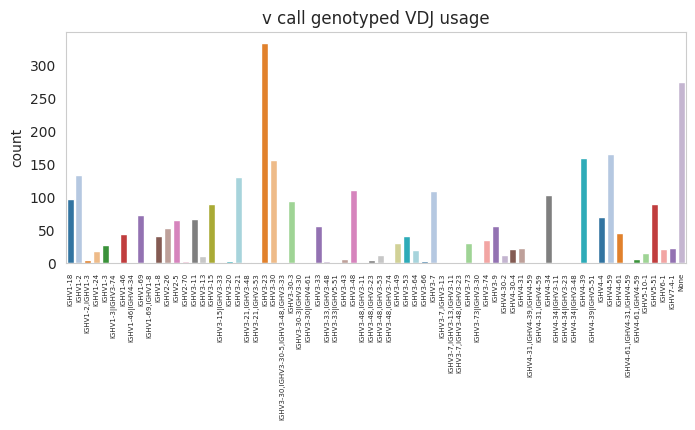

In [19]:
ddl.pl.barplot(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="v_call_genotyped_VDJ",
    normalize=False,
    sort_descending=None,
    palette="tab20",
    xtick_fontsize=5,
)

We’ve got stacked bar plots.

(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'multiple stacked bar plot : isotype status usage'}, xlabel='isotype_status', ylabel='count'>)

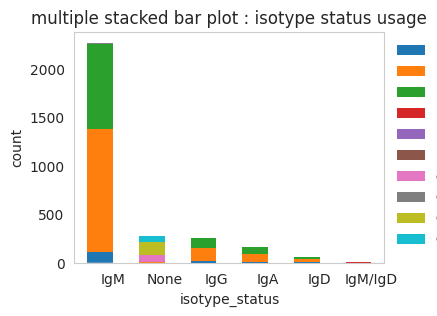

In [20]:
ddl.pl.stackedbarplot(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="isotype_status",
    groupby="locus_status",
    xtick_rotation=0,
    figsize=(4, 3),
)

These can be normalised to add up to 1 for each column.

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'multiple stacked bar plot : v call genotyped VDJ usage'}, xlabel='v_call_genotyped_VDJ', ylabel='proportion'>)

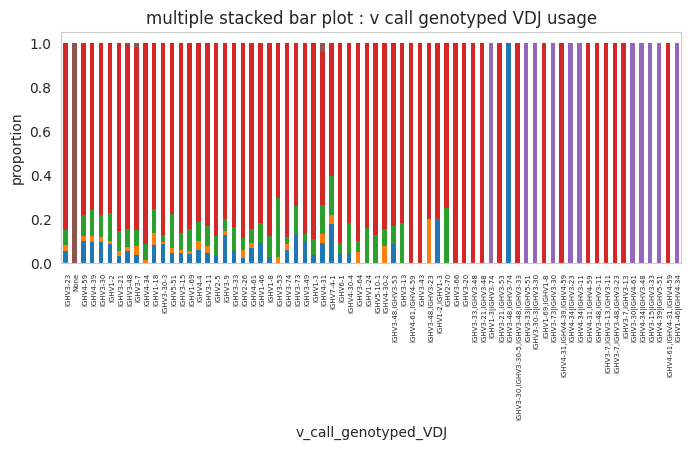

In [21]:
ddl.pl.stackedbarplot(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="v_call_genotyped_VDJ",
    groupby="isotype_status",
    normalize=True,
    xtick_fontsize=5,
)

We’ve also got a spectratype plot, which shows the distribution of the CDR3 length for the various contigs.

(<Figure size 500x300 with 1 Axes>,
 <Axes: xlabel='junction_length', ylabel='count'>)

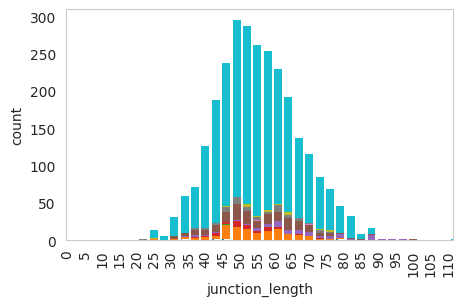

In [22]:
ddl.pl.spectratype(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="junction_length",
    groupby="c_call",
    locus="IGH",
    width=2.3,
)

Another common V(D)J analysis request is to examine the distribution of shared clonotypes between cells of different metadata groups. Dandelion can do this as a circos plot.

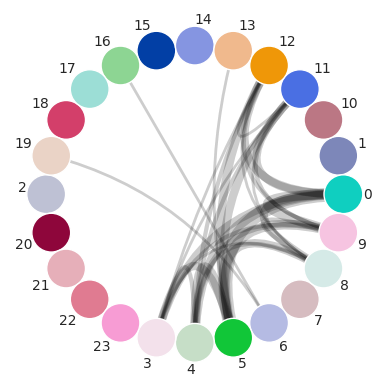

In [23]:
ddl.tl.clone_overlap(adata, groupby="leiden", weighted_overlap=True)
ddl.pl.clone_overlap(adata, groupby="leiden", weighted_overlap=True)

There’s also a heatmap on offer.

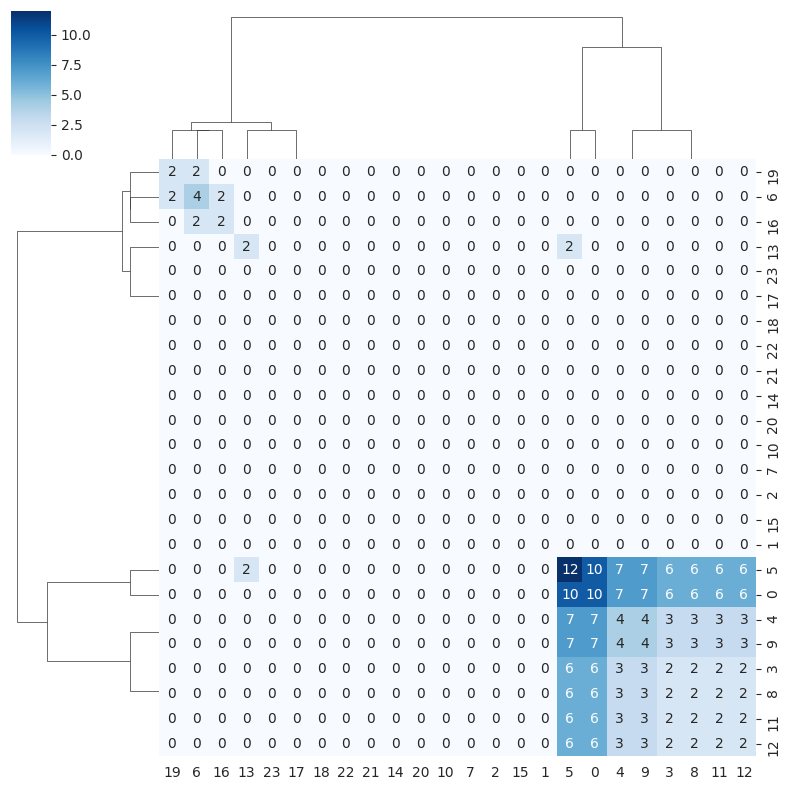

In [24]:
ddl.pl.clone_overlap(
    adata,
    groupby="leiden",
    weighted_overlap=True,
    as_heatmap=True,
    # seaborn clustermap kwargs
    cmap="Blues",
    annot=True,
    figsize=(8, 8),
    annot_kws={"size": 10},
)

Save the objects, like so.

In [25]:
adata.write("demo-gex-processed.h5ad")
vdj.write("demo-vdj-processed.h5ddl")


# V(D)J pseudobulk feature space

In [ ]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")

This notebook makes use of `Milopy` and `Palantir`, two packages that are not formally `Dandelion`’s dependencies. V(D)J feature space applications are open-ended, this is just one of them. Be sure to install the packages beforehand if you want to follow along.

In [ ]:
!pip install git+https://github.com/emdann/milopy.git palantir -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import milopy.core as milo
import palantir

#required because of Palantir
%matplotlib inline

sc.settings.set_figure_params(dpi=80)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


We’ve prepared a demo object based on the TCR trajectory shown in the manuscript for you to use here. It’s had some analysis done on the GEX, and has Dandelion-derived contig information merged into it. You can download it from the ftp site as per below.

It’s possible to use V(D)J information that comes from other sources than Dandelion processing, e.g. the pseudobulking will work with Scirpy output. The functions are just calibrated to work with Dandelion’s structure by default.

In [ ]:
if not os.path.exists("demo-pseudobulk.h5ad"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-pseudobulk.h5ad")


Prior to performing the pseudobulking, it is recommended to run `ddl.tl.setup_vdj_pseudobulk()`. This will subset the object to just cells with paired chains, and prepare appropriately named and formatted columns for the pseudobulking function to use as defaults.

If working with non-Dandelion V(D)J processing, subset your cells to ones with at least a full pair of chains, and ensure that you have four columns in place which contain the V(D)J calls for both of the identified primary chains. Scirpy stores this information natively.

If you are wanting to include D calls (disabled by default), the recommendation is to subset to only cells/contigs with d_call annotated otherwise the separation could be unreliable (due to missing d_call because of technical reasons rather than biology). Please look at the options for `ddl.tl.setup_vdj_pseudobulk()` carefully to tailor to your use case.

We will proceed with the default settings, which is to only consider the primary V and J calls (productive and highest UMI).

In [ ]:
adata = sc.read("demo-pseudobulk.h5ad")
adata = ddl.tl.setup_vdj_pseudobulk(adata)


We’re going to be using Milopy to create pseudobulks. Construct a neighbour graph with many neighbours, following Milopy protocol, and then sample representative neighbourhoods from the object. This saves a cell-by-pseudobulk matrix into `adata.obsm["nhoods"]`. Use this graph to generate a UMAP as well.

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_neighbors=50)
milo.make_nhoods(adata)
sc.tl.umap(adata)

Now we are armed with everything we need to construct the V(D)J feature space. Pseudobulks can be defined either via passing a list of `.obs` metadata columns, the unique values of the combination of which will serve as individual pseudobulks (via `obs_to_bulk`), or via an explicit cell-by-pseudobulk matrix (via `pbs`). Milopy created one of those for us, so we can use that as input.

The cell type annotation lives in `.obs["anno_lvl_2_final_clean"]`. Let’s tell the function that we want to take the most common value per pseudobulk with us to the new V(D)J feature space object.

For non-Dandelion V(D)J processing, use the cols argument to specify which .obs columns contain the V(D)J calls for the identified primary chains. For Scirpy, this would mean specifying e.g. `cols = ['IR_VDJ_1_v_gene', 'IR_VDJ_1_j_gene', 'IR_VJ_1_v_gene', 'IR_VJ_1_j_gene']`.

In [ ]:
pb_adata = ddl.tl.vdj_pseudobulk(
    adata, pbs=adata.obsm["nhoods"], obs_to_take="anno_lvl_2_final_clean"
)

The new object has pseudobulks as observations, and the unique encountered V(D)J genes as the features. We can see the per-pseudobulk annotation, and `.uns["pseudobulk_assigments"]`. In our case it’s just a copy of the `pbs` argument, but if we were to go for `obs_to_bulk` this would be a cells by pseudobulks matrix capturing the assignment of the original cells.

In [ ]:
pb_adata


AnnData object with n_obs × n_vars = 1361 × 160
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count'
    obsm: 'pbs'

Now that we have our V(D)J feature space pseudobulk object, we can do things with it. Let’s run a PCA on it. The development trajectory is very nicely captured in the first two PC dimensions.

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

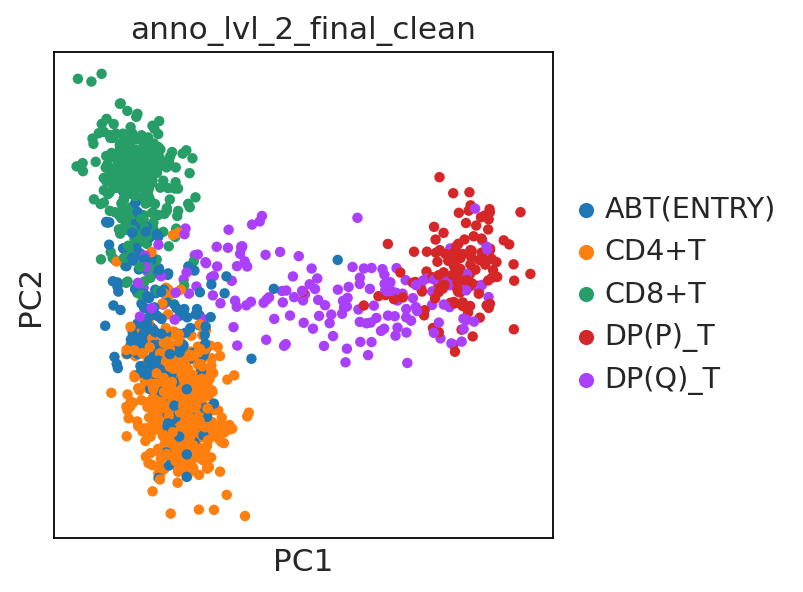

In [ ]:
sc.tl.pca(pb_adata)
sc.pl.pca(pb_adata, color="anno_lvl_2_final_clean")


Let’s define the start of our trajectory as the right-most cell, the CD4 terminal state as the bottom-most cell, and the CD8 terminal state as the top-most cell. We can then follow Palantir protocol to generate a diffusion map and run pseudotime. Once done, we rename the terminal states to be more informative.

In [ ]:
rootcell = np.argmax(pb_adata.obsm["X_pca"][:, 0])
terminal_states = pd.Series(
    ["CD8+T", "CD4+T"],
    index=pb_adata.obs_names[
        [
            np.argmax(pb_adata.obsm["X_pca"][:, 1]),
            np.argmin(pb_adata.obsm["X_pca"][:, 1]),
        ]
    ],
)

# Run diffusion maps
pca_projections = pd.DataFrame(pb_adata.obsm["X_pca"], index=pb_adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

pr_res = palantir.core.run_palantir(
    ms_data,
    pb_adata.obs_names[rootcell],
    num_waypoints=500,
    terminal_states=terminal_states.index,
)

pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

Determing nearest neighbor graph...
Sampling and flocking waypoints...
Time for determining waypoints: 0.0023829062779744466 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.33614931503931683 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


We can easily transfer the inferred pseudotime and branching probabilities to the pseudobulk object with the aid of a helper function.

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

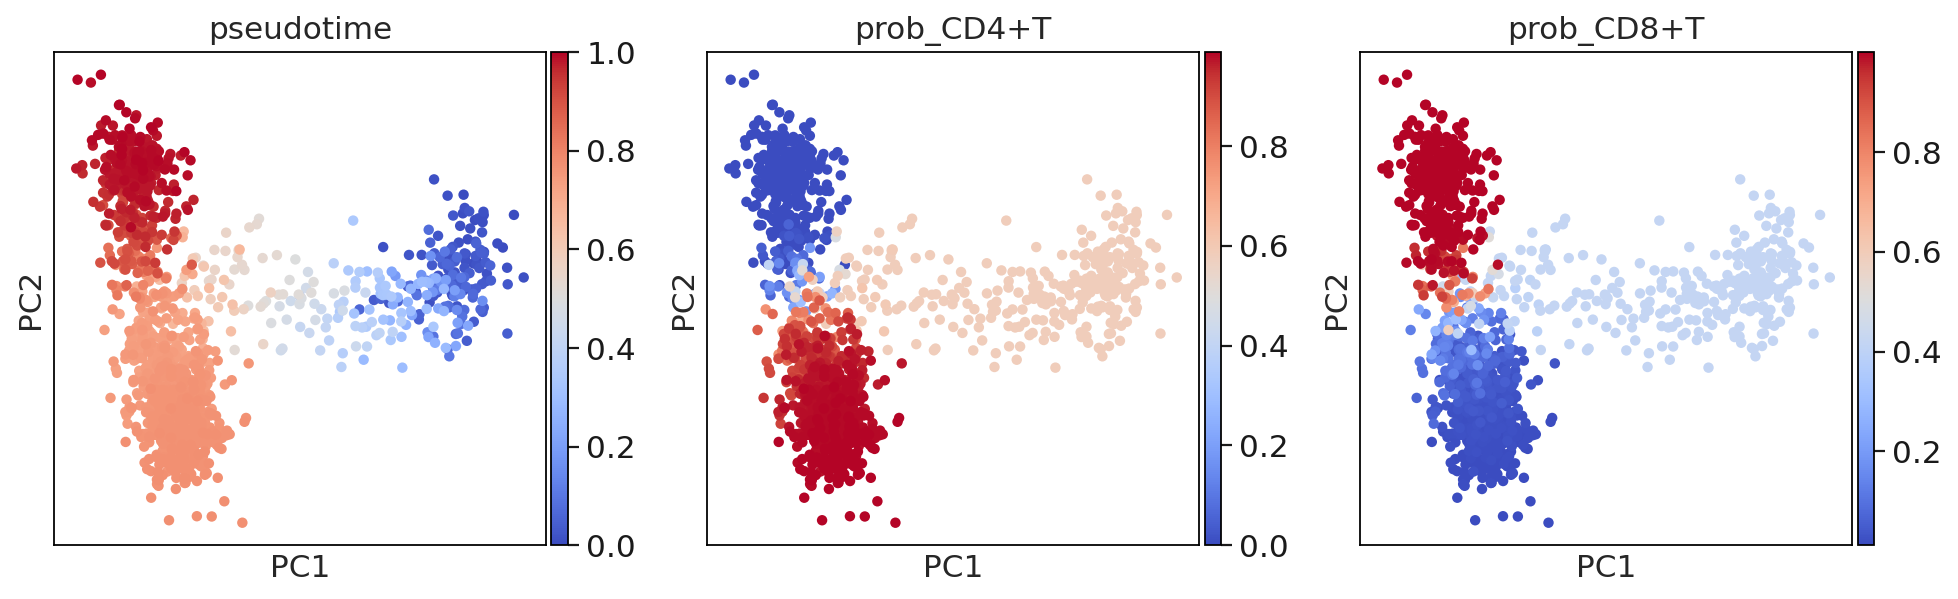

In [ ]:
pb_adata = ddl.tl.pseudotime_transfer(pb_adata, pr_res)
sc.pl.pca(
    pb_adata,
    color=["pseudotime", "prob_CD4+T", "prob_CD8+T"],
    color_map="coolwarm",
)

We can project back our findings to the original cell space object via another helper function. This will remove any cells not in any of the pseudobulks. In the event of a cell belonging to multiple pseudobulks, the cell’s pseudotime will be the average of the pseudobulks weighted by the inverse of the pseudobulk size.

number of cells removed due to not belonging to any neighbourhood 87


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

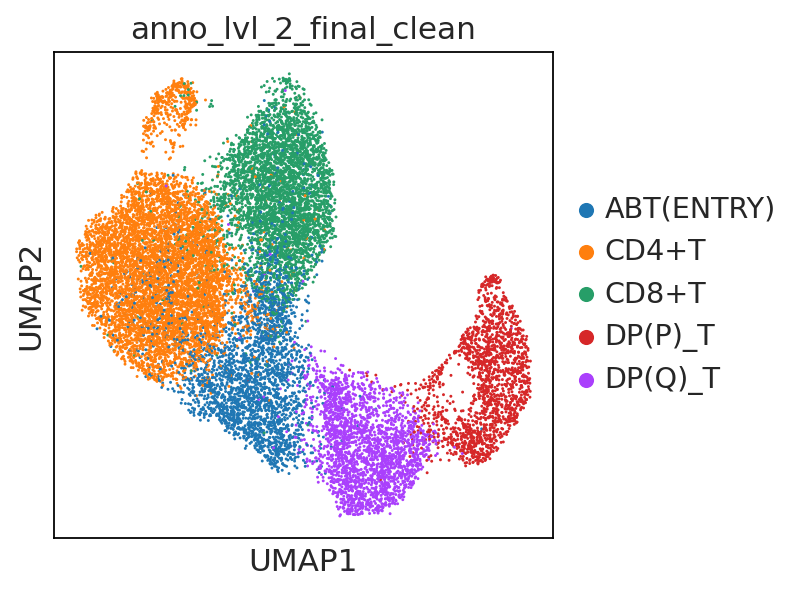

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

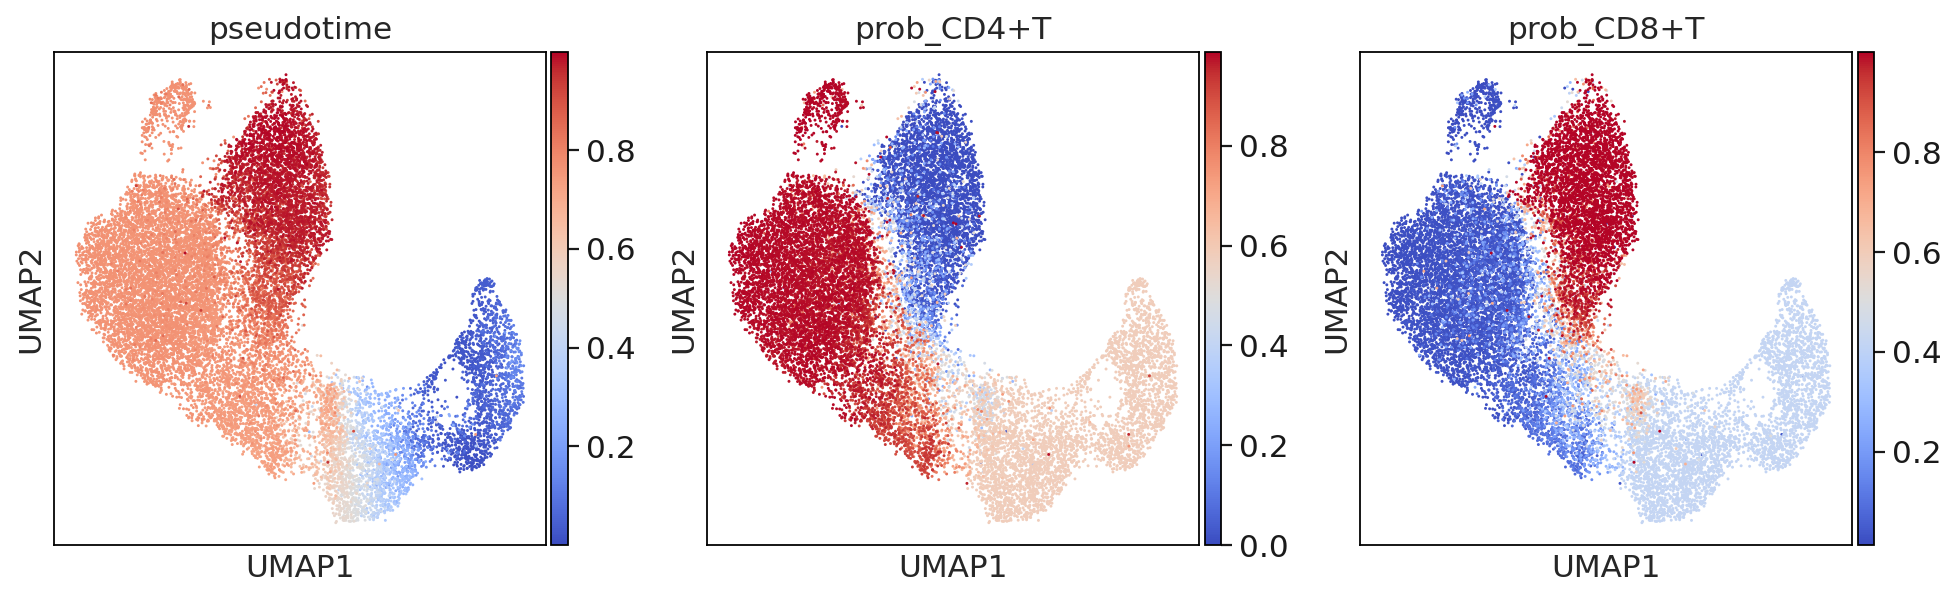

In [ ]:
bdata = ddl.tl.project_pseudotime_to_cell(
    adata, pb_adata, terminal_states.values
)
sc.pl.umap(bdata, color=["anno_lvl_2_final_clean"])
sc.pl.umap(
    bdata,
    color=["pseudotime", "prob_CD4+T", "prob_CD8+T"],
    color_map="coolwarm",
)

For more in-depth tutorial and examples of the workflow, please visit `dandelion`'s [documentation](https://sc-dandelion.readthedocs.io/) and [github repository](https://github.com/zktuong/dandelion).